# Plant Pathology 2020 - FGVC7

Identify the category of foliar diseases in apple tree

# Problem Statement
Misdiagnosis of the many diseases impacting agricultural crops can lead to misuse of chemicals leading to the emergence of resistant pathogen strains, increased input costs, and more outbreaks with significant economic loss and environmental impacts. Current disease diagnosis based on human scouting is time-consuming and expensive, and although computer-vision based models have the promise to increase efficiency, the great variance in symptoms due to age of infected tissues, genetic variations, and light conditions within trees decreases the accuracy of detection.

Credits:https://arxiv.org/abs/2004.11958

# Specific Objectives
Objectives of ‘Plant Pathology Challenge’ are to train a model using images of training dataset to 1) Accurately classify a given image from testing dataset into different diseased category or a healthy leaf; 2) Accurately distinguish between many diseases, sometimes more than one on a single leaf; 3) Deal with rare classes and novel symptoms; 4) Address depth perception—angle, light, shade, physiological age of the leaf; and 5) Incorporate expert knowledge in identification, annotation, quantification, and guiding computer vision to search for relevant features during learning

<img src="Potato-leaf-blight.jpg"> 

## INSTALLATION

In [2]:
from utils import *

In [3]:
import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.metrics import roc_auc_score
from fastai2.vision.all import *

In [5]:
import zipfile
with zipfile.ZipFile(Path("pp3.zip"), 'r') as zip_ref:
    zip_ref.extractall("data_plant14")

In [6]:
from pathlib import Path
path = Path("data_plant14/images")

In [7]:
import pandas as pd
df = pd.read_csv('data_plant14/train.csv')
df2 = pd.read_csv("data_plant14/test.csv")

In [8]:
imglabels = list(df.columns[1:])
df["labels"] = df.apply(lambda x: imglabels[x.values[1:].argmax()], axis=1)

In [9]:
df.head()

image_id  healthy  multiple_diseases  rust  scab             labels
0  Train_0        0                  0     0     1               scab
1  Train_1        0                  1     0     0  multiple_diseases
2  Train_2        1                  0     0     0            healthy
3  Train_3        0                  0     1     0               rust
4  Train_4        1                  0     0     0            healthy

In [10]:
dls = ImageDataLoaders.from_df(df,
                               path=Path("data_plant14"), 
                               suff=".jpg", 
                               folder="images",
                               label_col="labels",
                               item_tfms=RandomResizedCrop(224, min_scale=0.5),
                               batch_tfms=aug_transforms())

## DATA EXPLORATION

In [11]:
df.head()

image_id  healthy  multiple_diseases  rust  scab             labels
0  Train_0        0                  0     0     1               scab
1  Train_1        0                  1     0     0  multiple_diseases
2  Train_2        1                  0     0     0            healthy
3  Train_3        0                  0     1     0               rust
4  Train_4        1                  0     0     0            healthy

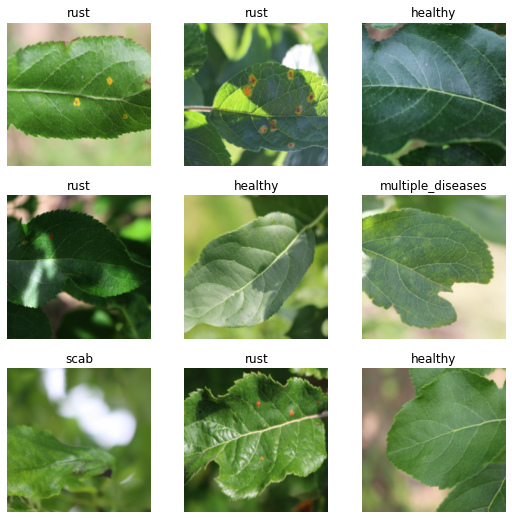

In [12]:
dls.show_batch()

In [13]:
fig = go.Figure([go.Pie(labels=df.columns[1:5],
           values=df.iloc[:, 1:].sum().values)])
fig.update_layout(title_text="Data Distribution", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.show()

## Data Augmentation

In [56]:
size = 256
batch_tfms = [RandomResizedCrop(size), 
                                 *aug_transforms(mult=1.0, do_flip=True, 
                                                 max_rotate=30.0, max_zoom=1.5,
                                                  max_lighting=.8, max_warp=0.3, 
                                                 p_lighting=.9),
                                 Normalize.from_stats(*imagenet_stats)]

In [57]:
def get_x(r):
    a = r['image_id']+".jpg"
    return path/a
def get_y(r): return r['labels']

In [58]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x = get_x, get_y = get_y,
                   item_tfms=Resize(256),
                   batch_tfms=batch_tfms
                  ,splitter = RandomSplitter(valid_pct=0.15,seed=10))

In [14]:
dls = dblock.dataloaders(df,bs=16)

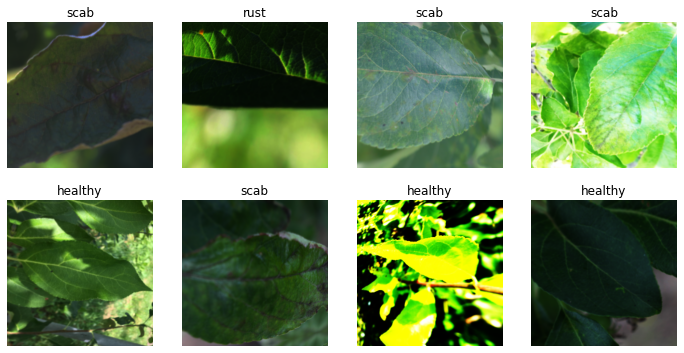

In [15]:
dls.train.show_batch(max_n =8,nrows=2)

# Model Architecture

## 1. Resnet-18

In [16]:
from fastai2.callback.fp16 import *

In [26]:
learn = cnn_learner(dls, resnet18, loss_func= LabelSmoothingCrossEntropy(), metrics=[accuracy,error_rate])

### Reason For Using LabelSmoothingCrossEntropy()

<img src="smoothing.png" >
Credits: https://rickwierenga.com/blog/machine%20learning/LabelSmoothing.html

In [71]:
learn.unfreeze()

In [28]:
##dls.train.show_batch

In [29]:
learn.fine_tune(11)

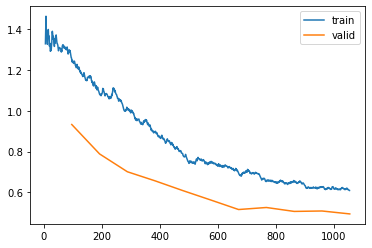

In [32]:
learn.recorder.plot_loss()

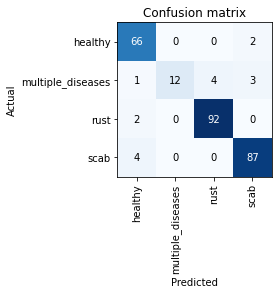

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Finding Where The Model Is Not Performing Well

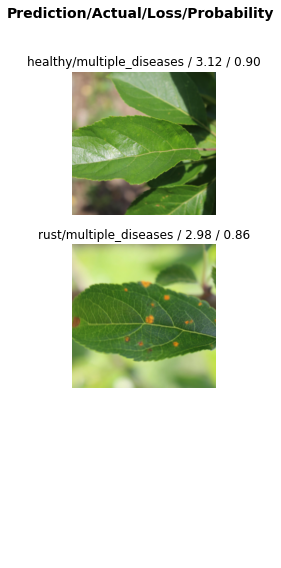

In [34]:
interp.plot_top_losses(2, nrows=3)

In [35]:
learn.save(f"resnet-18-first")

## Final Predictions For Test Set

In [37]:
tst_dl = dls.test_dl(df2)
test_pred_model_1 = learn.get_preds(dl=tst_dl,with_decoded=True)
a4  =test_pred_model_1[0].numpy()
df3 = pd.DataFrame(a4,columns=['healthy','multiple_diseases','rust','scab'])
l3 = []
for j in range(0,len(test_pred_model_1[2])):
    l3.append(str("Test_"+str(j)))
df3['image_id'] = l3
df3.to_csv("test19.csv",index=False)

In [38]:
df3.head()

healthy  multiple_diseases      rust      scab image_id
0  0.028320           0.154405  0.786654  0.030620   Test_0
1  0.019759           0.020715  0.943712  0.015814   Test_1
2  0.004501           0.005779  0.002019  0.987701   Test_2
3  0.955244           0.010385  0.030477  0.003894   Test_3
4  0.027140           0.044194  0.899941  0.028725   Test_4

### Find Good Learning Rate

In [40]:
learn = cnn_learner(dls, resnet18, loss_func= LabelSmoothingCrossEntropy(), metrics=[accuracy,error_rate])

In [41]:
learn.unfreeze()

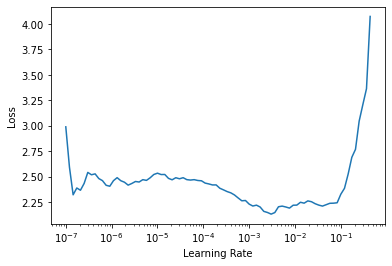

In [42]:
min_learning_rate,_ = learn.lr_find()

In [43]:
print(min_learning_rate)

0.0003019951749593019


In [ ]:
??learn.lr_find

In [44]:
learn.fit_one_cycle(13, min_learning_rate)

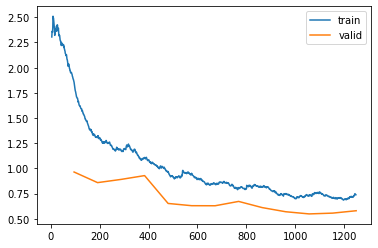

In [45]:
learn.recorder.plot_loss()

In [46]:
al_preds, val_labels = learn.get_preds()

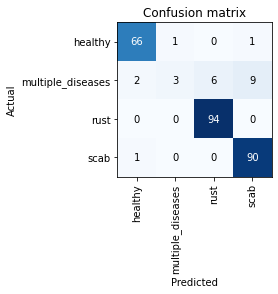

In [47]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Finding Where The Model Is Not Performing Well

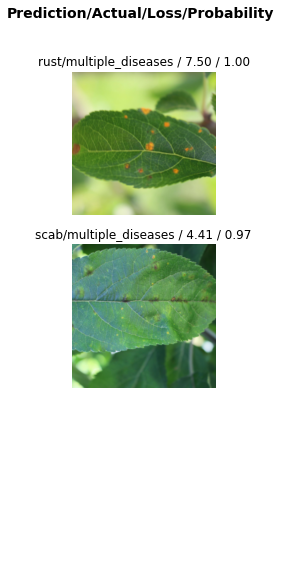

In [48]:
interp.plot_top_losses(2, nrows=3)

## Predictions

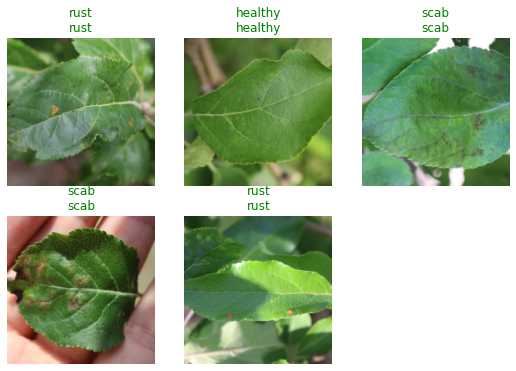

In [49]:
learn.show_results(max_n=5)

In [51]:
learn.save(f"resnet-18-second")

## Final Predictions For Test Set

In [52]:
tst_dl = dls.test_dl(df2)
test_pred_model_2 = learn.get_preds(dl=tst_dl,with_decoded=True)
a4  =test_pred_model_2[0].numpy()
df3 = pd.DataFrame(a4,columns=['healthy','multiple_diseases','rust','scab'])
l3 = []
for j in range(0,len(test_pred_model_2[2])):
    l3.append(str("Test_"+str(j)))
df3['image_id'] = l3
df3.to_csv("test20.csv",index=False)

## 2. Efficient-net-b2

In [ ]:
!pip install efficientnet-pytorch

In [53]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained("efficientnet-b2")

Loaded pretrained weights for efficientnet-b2


In [54]:
torch.cuda.empty_cache()

In [55]:
model._fc = nn.Linear(1408, dls.c)

In [56]:
learn2 = Learner(dls, model, metrics=[accuracy,error_rate]).to_fp16()

### Model Fit using One Cycle Method

In [66]:
learn2.fit_one_cycle(13)

In [67]:
learn2.unfreeze()
learn2.fine_tune(5)

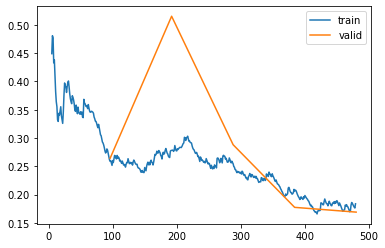

In [68]:
learn2.recorder.plot_loss()

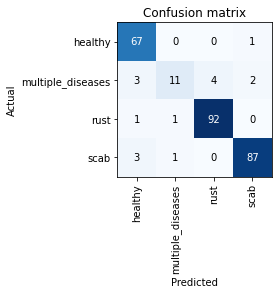

In [69]:
interp = ClassificationInterpretation.from_learner(learn2)
interp.plot_confusion_matrix()

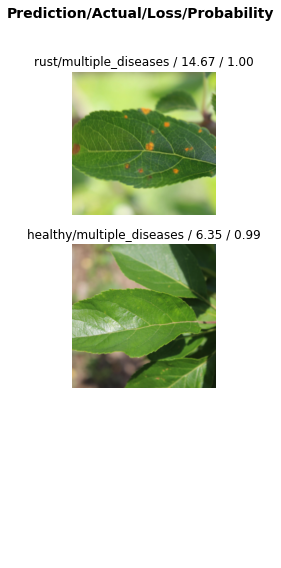

In [61]:
interp.plot_top_losses(2, nrows=3)

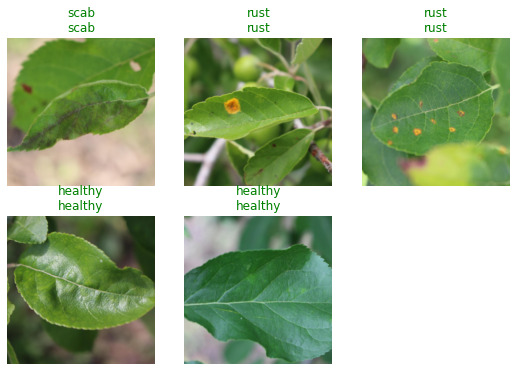

In [62]:
learn2.show_results(max_n=5)

In [ ]:
#from fastai2.vision.core import PILImage

## Final Predictions For Test Set

In [63]:
tst_dl = dls.test_dl(df2)
test_pred_model_3 = learn.get_preds(dl=tst_dl,with_decoded=True)
a4  =test_pred_model_3[0].numpy()
df3 = pd.DataFrame(a4,columns=['healthy','multiple_diseases','rust','scab'])
l3 = []
for j in range(0,len(test_pred_model_3[2])):
    l3.append(str("Test_"+str(j)))
df3['image_id'] = l3
df3.to_csv("test22.csv",index=False)

In [65]:
df3.head()

healthy  multiple_diseases      rust      scab image_id
0  0.015854           0.022982  0.954588  0.006576   Test_0
1  0.012366           0.016048  0.960674  0.010912   Test_1
2  0.001319           0.001963  0.000812  0.995906   Test_2
3  0.974887           0.009190  0.008759  0.007164   Test_3
4  0.000209           0.000382  0.998953  0.000456   Test_4

In [ ]:
??learn.fine_tune

In [ ]:
#dls.one_batch()

## Credits: Efficient-net-b2 
   https://www.kaggle.com/ronyroy/effnet-fastai-folds-x5
   

## Credits: FastAI Library https://dev.fast.ai/